<a href="https://colab.research.google.com/github/CoronelChefe/An-lise-Explorat-ria-Dutos-PB/blob/main/trabalho_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório de Projeto Final
- Prof. Gustavo Oliveira - Semestre 2021/1**
- Ramon Azevedo dos Santos Cavalcanti





## Resumo

Este relatório tem a finalidade de analisar os dados referente a movimentação do gás natural nas regiões do Brasil. A ideia seria mapear o nível de produtividade desse insumo principalmente na região Nordeste, já que o investimento em gasodutos veio à tona, devido também à atual crise elétrica. Aplicamos a técnica de heatmap para destacar o potencial para produção de gás natural nas regiões do Brasil.

## Descrição do problema

No Brasil, com a crise de energia elétrica, tomou impulso um grande esforço do governo brasileiro para incrementar a expansão da potência instalada através de usinas termelétricas alimentadas por gás natural (PRAÇA, 2003).

Em geral, as perspectivas para a utilização plena e racional do gás natural no mundo são bastante promissoras, pois é possível obter alta eficiência energética utilizando sistemas de cogeração, produzindo conjuntamente calor (ou frio) e energia. Além disso, diversas outras aplicações no setor veicular, industrial e residencial podem ser incrementadas, configurando-se nos chamados “usos nobres” do gás natural (SANTOS, 2002).

A questão central que buscamos responder é: *podemos construir um mapa de calor sobre as regiões do Brasil pelo qual possamos, rapidamente, visualizar o potencial de geração de gás natural no Nordeste?* *Podemos enxergar quais seriam os indices de produtividade, disponibilidade e consumo na região do Nordeste ao longo dos anos?* *Durante o período de pandemia houve algum crescimento no que diz respeito ao aumento do consumo, produção e disponibilidade na área?*  *Através de técnicas de predição utilizando o método regressão linear, é possível verificar se haverá gás natural, para atender à demanda da região do Nordeste, por quantos anos?*

## Metodologia de solução

Para resolver o problema proposto, usamos a seguinte metodologia:


1.  Coleta de dados no site da Agência Nacional do Petróleo, Gás Natural e Biocombustíveis (ANP), órgão regulador das atividades que integram as indústrias de petróleo, gás natural e de biocombustíveis no Brasil. Abaixo estão os códigos que foram utilizados para realizar a coleta dos arquivos de *dataframe* diretamente do site da ANP.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from xgboost import XGBRegressor


plt.rcParams['figure.dpi'] = 300
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("ticks")

In [ ]:
df_cons = pd.read_csv(
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ppgn-el/consumo-proprio-gn1000m3-2000-2021.csv",
    sep=";",
)
df_prod = pd.read_csv(
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ppgn-el/producao-gas-natural-1000m3-1997-2021.csv",
    sep=";",
)
df_disp = pd.read_csv(
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/ppgn-el/gn-disponivel-1000m3-2000-2021.csv",
    sep=";",
)

2.  Para limpeza e processamento dos dados foram utilizados os módulos pandas e numpy da linguagem da programação Python para construição dos *DataFrames* contendo os parâmetros mais relevantes da análise. A seguir, mostramos como foi realizada a limpeza dos dados colhidos:


Trocando as vírgulas por ponto nos valores númericos, pois o Pandas não funcionaria corretamente caso seja utilizado vírgulas como separador decimal.

In [ ]:
for idx in range(len(df_cons)):
    df_cons.at[idx, "CONSUMO"] = df_cons.at[idx, "CONSUMO"].replace(",", ".")
for idx in range(len(df_prod)):
    df_prod.at[idx, "PRODUÇÃO"] = df_prod.at[idx, "PRODUÇÃO"].replace(",", ".")
for idx in range(len(df_disp)):
    df_disp.at[idx, "DISPONÍVEL"] = df_disp.at[idx, "DISPONÍVEL"].replace(",", ".")

Convertendo o `datatype` das colunas em númerico.

In [ ]:
df_cons["CONSUMO"] = pd.to_numeric(df_cons["CONSUMO"])
df_prod["PRODUÇÃO"] = pd.to_numeric(df_prod["PRODUÇÃO"])
df_disp["DISPONÍVEL"] = pd.to_numeric(df_disp["DISPONÍVEL"])

Renomeando as colunas para que seja possível utilizar o método `.query()` do Pandas para realizar a filtragem dos dados, pois alguns caracteres presentes na língua portuguesa não são suportados pelo método `.query()`.

In [ ]:
df_cons = df_cons.rename(
    columns={
        "ANO": "ano",
        "MÊS": "mes",
        "GRANDE REGIÃO": "granderegiao",
        "UNIDADE DA FEDERAÇÃO": "unidadedafederacao",
        "PRODUTO": "produto",
        "LOCALIZAÇÃO": "localizacao",
        "CONSUMO": "consumo",
    }
)
df_prod = df_prod.rename(
    columns={
        "ANO": "ano",
        "MÊS": "mes",
        "GRANDE REGIÃO": "granderegiao",
        "UNIDADE DA FEDERAÇÃO": "unidadedafederacao",
        "PRODUTO": "produto",
        "LOCALIZAÇÃO": "localizacao",
        "PRODUÇÃO": "producao",
    }
)
df_disp = df_disp.rename(
    columns={
        "ANO": "ano",
        "MÊS": "mes",
        "GRANDE REGIÃO": "granderegiao",
        "UNIDADE DA FEDERAÇÃO": "unidadedafederacao",
        "PRODUTO": "produto",
        "LOCALIZAÇÃO": "localizacao",
        "DISPONÍVEL": "disponivel",
    }
)

Agrupando todos os dados em um `DataFrame` apenas, para que seja possível trabalhar de forma mais eficiente e também garantir que trabalhemos apenas com datas que estão presentes nas três tabelas

In [ ]:
df_final = pd.merge(
    pd.merge(
        df_cons,
        df_prod,
        on=[
            "produto",
            "ano",
            "mes",
            "granderegiao",
            "unidadedafederacao",
            "localizacao",
        ],
    ),
    df_disp,
    on=[
        "produto",
        "ano",
        "mes",
        "granderegiao",
        "unidadedafederacao",
        "localizacao",
    ],
)

Criando uma nova coluna, `datacompleta`, que irá receber a data completa no formato DD/MM/AAAA para cada entrada, e convertendo-a para o `datatype` do tipo `datatetime`. Além disso foi criado também uma nova coluna, `mes_numerico` para representar o mês de forma numérica.

In [ ]:
data_completa = []
mes_numero = []
for idx, ano in enumerate(df_final['ano']):
    mes = df_final.at[idx,'mes']
    if mes == 'JAN':
        mes = "01"
    elif mes == 'FEV':
        mes = '02'
    elif mes == 'MAR':
        mes = '03'
    elif mes == 'ABR':
        mes = '04'
    elif mes == 'MAI':
        mes = '05'
    elif mes == 'JUN':
        mes = '06'
    elif mes == 'JUL':
        mes = '07'
    elif mes == 'AGO':
        mes = '08'
    elif mes == 'SET':
        mes = '09'
    elif mes == 'OUT':
        mes = '10'
    elif mes == 'NOV':
        mes = '11'
    elif mes == 'DEZ':
        mes = '12'
    data = f"{str(ano)}/{mes}/01"
    mes_numero.append(mes)
    data_completa.append(data)

df_final['datacompleta'] = data_completa
df_final['mes_numerico'] = mes_numero

Transformando a coluna de `datacompleta` para o `datatype datetime64` 

In [ ]:
df_final['datacompleta'].apply(pd.to_datetime, infer_datetime_format=True, errors="coerce")

0      2000-08-01
1      2000-09-01
2      2000-06-01
3      2000-07-01
4      2000-12-01
          ...    
5730   2021-01-01
5731   2021-10-01
5732   2021-05-01
5733   2021-04-01
5734   2021-03-01
Name: datacompleta, Length: 5735, dtype: datetime64[ns]

No fim, ficamos com um *DataFrame* `df_final` que contém todos os dados disponíveis das 3 bases de dados coletadas (produção, disponibilidade e consumo).

In [ ]:
df_final.head(5)

ano  mes     granderegiao   unidadedafederacao      produto localizacao  \
0  2000  AGO  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL         MAR   
1  2000  SET  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL         MAR   
2  2000  JUN  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL         MAR   
3  2000  JUL  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL         MAR   
4  2000  DEZ  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL         MAR   

   consumo  producao  disponivel datacompleta mes_numerico  
0 4,344.21 75,850.51   40,493.71   2000/08/01           08  
1 5,063.35 70,891.20   33,923.55   2000/09/01           09  
2 4,845.85 73,282.75   36,890.90   2000/06/01           06  
3 5,175.34 74,975.48   35,342.44   2000/07/01           07  
4 4,709.74 76,444.36   42,537.32   2000/12/01           12

### Dataframes de métricas notáveis

Com relação a base de dados da ANP para produção, disponibilidade e consumo, é valido salientar que somente os ***índices nacionais*** são levados em consideração. Ou seja, qualquer valor referente ao uso de gás natural no Brasil, que seja de ***origem estrangeira***, não é computado nos índices da ANP. Isso explica o motivo da **região sul** do país apresentar valores nulos para esse três índices, tendo em vista que todo o gás natural consumido nessa região provem único e exclusivamente da Bolívia (SULGÁS, 2021).

Todos os números para consumo, produção e disponibilidade têm como unidade de medida ***mil m³*** (ANP, 2021).

Para região Centro-oeste, especificamente nos estados do Mato Grosso e Mato Grosso do Sul, todo o gás comprado estava destinado exclusivamente às Termelétricas, de modo que o gráfico de consumo se apresenta nulo, já os gráficos de disponibilidade e produção também não assumem valores relevantes, pois o principal fornecedor da região é através do Gasbol (Gasoduto Bolívia-Brasil) (MIRKO, 2009).

A seguir, mostramos um recorte de um dos *DataFrames* apresentando as médias de ***consumo, disponibilidade e produção*** de Gás Natural, no período de 2019 até 2021, de cada região do Brasil.

In [ ]:
df_final.query("ano >= 2019").groupby(["granderegiao","ano"]).mean().round(2)

consumo   producao  disponivel
granderegiao    ano                                  
REGIÃO NORDESTE 2019  2,325.40  33,340.98   26,124.52
                2020  1,314.32  25,330.56   21,731.02
                2021  1,116.27  32,204.70   29,349.21
REGIÃO NORTE    2019  7,352.22 232,128.31  101,046.19
                2020  6,711.64 206,549.03  105,844.39
                2021  6,479.67 205,161.62  109,344.77
REGIÃO SUDESTE  2019 64,717.96 477,111.82  222,219.16
                2020 69,479.47 528,399.03  199,733.03
                2021 68,165.09 544,326.44  182,393.54
REGIÃO SUL      2019      0.00       0.00        0.00
                2020      0.00       0.00        0.00
                2021      0.00       0.00        0.00

Em seguida realizamos a análise de correlação entre as colunas de consumo, produção e disponibilidade.

Como naturalmente se é esperado, o índice de correlação entre as três colunas: `producao`, `disponivel` e `consumo` é bastante elevado:

In [ ]:
corr = df_final.drop(columns=["ano"]).corr()
corr

consumo  producao  disponivel
consumo        1.00      0.92        0.88
producao       0.92      1.00        0.93
disponivel     0.88      0.93        1.00

### Carregamento dos dados geoespaciais

Carregamento dos dados geográficos para o `geopandas`:

In [ ]:
#Colunas que não serão utilizadas
    #id_elementoprodutor
    #cd_insumo_orgao
    #id_produtor
    #nomeabrev
    #nr_insumo_mes
    #nr_insumo_ano
    #tx_insumo_documento
    #geometriaaproximada

import geopandas as gpd
info_ufs = gpd.read_file('https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bcim/versao2016/geopackage/bcim_2016_21_11_2018.gpkg', layer='lim_unidade_federacao_a')
info_ufs = info_ufs.drop(columns=['id_elementoprodutor', 'cd_insumo_orgao',
                                 'id_produtor','nomeabrev','nr_insumo_mes',
                                 'nr_insumo_ano','tx_insumo_documento',
                                 'geometriaaproximada'])

Separando o *DataFrame* do mapa do Brasil em cinco, um para cada região, para que seja mais fácil trabalhar com as regiões de maneira individual.

In [ ]:
regiao = []
for cod in info_ufs['geocodigo']:
    if cod.startswith("1"):
        regiao.append("REGIÃO NORTE")
    elif cod.startswith("2"):
        regiao.append("REGIÃO NORDESTE")
    elif cod.startswith("3"):
        regiao.append("REGIÃO SUDESTE")
    elif cod.startswith("4"):
        regiao.append("REGIÃO SUL")
    else:
        regiao.append("REGIÃO CENTRO-OESTE")
info_ufs['granderegiao'] = regiao

grouped = info_ufs.groupby(info_ufs.granderegiao)
nordeste = grouped.get_group("REGIÃO NORDESTE")
norte = grouped.get_group("REGIÃO NORTE")
sudeste = grouped.get_group("REGIÃO SUDESTE")
sul = grouped.get_group("REGIÃO SUL")
centroeste = grouped.get_group("REGIÃO CENTRO-OESTE")


## Resultados, análise e discussão

É importante destacar que o gás natural encontrado em jazidas normalmente está associado ao petróleo. Constitui reservas finitas, e, conforme pesquisas realizadas pela IEA (Agência Internacional de Energia), caso se mantenha o ritmo de consumo médio da última década, as jazidas de gás natural irão se esgotar em 100 anos. Essa fonte energética agride menos o meio ambiente que o petróleo e o carvão mineral. No entanto, por ser de origem fóssil, sua combustão contribui para o efeito de estufa (FRANCISCO, W).

### Análise dos Resultados

Este relatório foi realizado através da análise de três base de dados, são elas: Consumo, Disponibilidade e Produção. A primeira obtivemos um total de 5745 registros, a segunda com 5752 e por fim a terceira com 6477 registros.



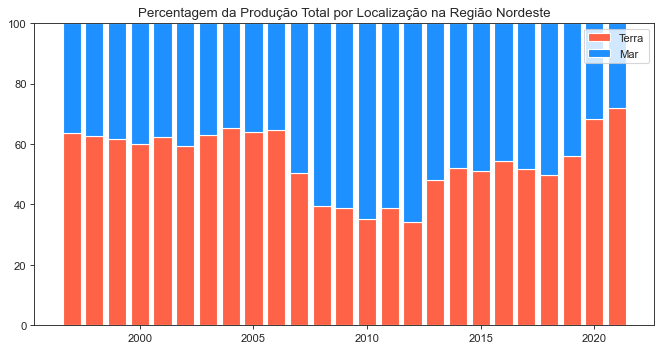

In [ ]:
df_nordeste = df_prod.query('granderegiao == "REGIÃO NORDESTE"')
df_nordeste = df_nordeste.groupby(["localizacao", "ano"]).sum().round(2)

anos = df_prod['ano'].drop_duplicates().to_list()
local = df_prod['localizacao'].drop_duplicates()
mar = df_nordeste.query('localizacao == "MAR"').reset_index().drop(columns=['localizacao'])['producao'].to_list()
terra = df_nordeste.query('localizacao == "TERRA"').reset_index().drop(columns=['localizacao','ano'])['producao'].to_list()

np_mar = np.array(mar)
np_terra = np.array(terra)
total = np_mar + np_terra

plt.figure(figsize=(10, 5),dpi=80)
plt.bar(anos, (np_terra/total)*100, color='#FF6347', label="Terra")
plt.bar(anos, (np_mar/total)*100, color='#1E90FF', bottom=(np_terra/total)*100, label="Mar")
plt.ylim(0,100)
plt.legend(loc="best")
plt.title('Percentagem da Produção Total por Localização na Região Nordeste')
plt.show()

O gráfico acima expressa a porcentagem da produção de gás natural no nordeste, através dele podemos perceber que este insumo é produzido em sua maior parte em instalações terrestres. Destaca-se também que o maior índice de produção de gás natural ocorreu nos anos de 2020 e 2021, período em que houve um aumento nos preços de outros combustíveis (gasolina, álcool, diesel).

In [ ]:
soma = df_final.groupby(["ano","granderegiao"]).sum()
media = df_final.groupby(["ano","granderegiao"]).mean()
desvio = df_final.groupby(["ano","granderegiao"]).std()

In [ ]:
soma.head(8)

consumo     producao   disponivel
ano  granderegiao                                          
2000 REGIÃO NORDESTE   496,710.61 4,873,160.96 3,191,202.13
     REGIÃO NORTE      101,192.00 2,000,200.00   153,909.44
     REGIÃO SUDESTE  1,139,792.76 6,362,310.09 3,100,494.89
     REGIÃO SUL            518.00    47,206.00         0.00
2001 REGIÃO NORDESTE   466,524.02 4,831,959.59 3,261,137.26
     REGIÃO NORTE      101,329.00 2,427,330.00   258,694.22
     REGIÃO SUDESTE  1,164,557.56 6,701,254.20 3,096,008.46
     REGIÃO SUL          1,896.00    38,254.00         0.00

In [ ]:
soma.reset_index(inplace=True)
media.reset_index(inplace=True)
desvio.reset_index(inplace=True)

De acordo com o *DataFrame* acima mostramos o total em mil metros cúbicos, separados por ano em cada região do Brasil.



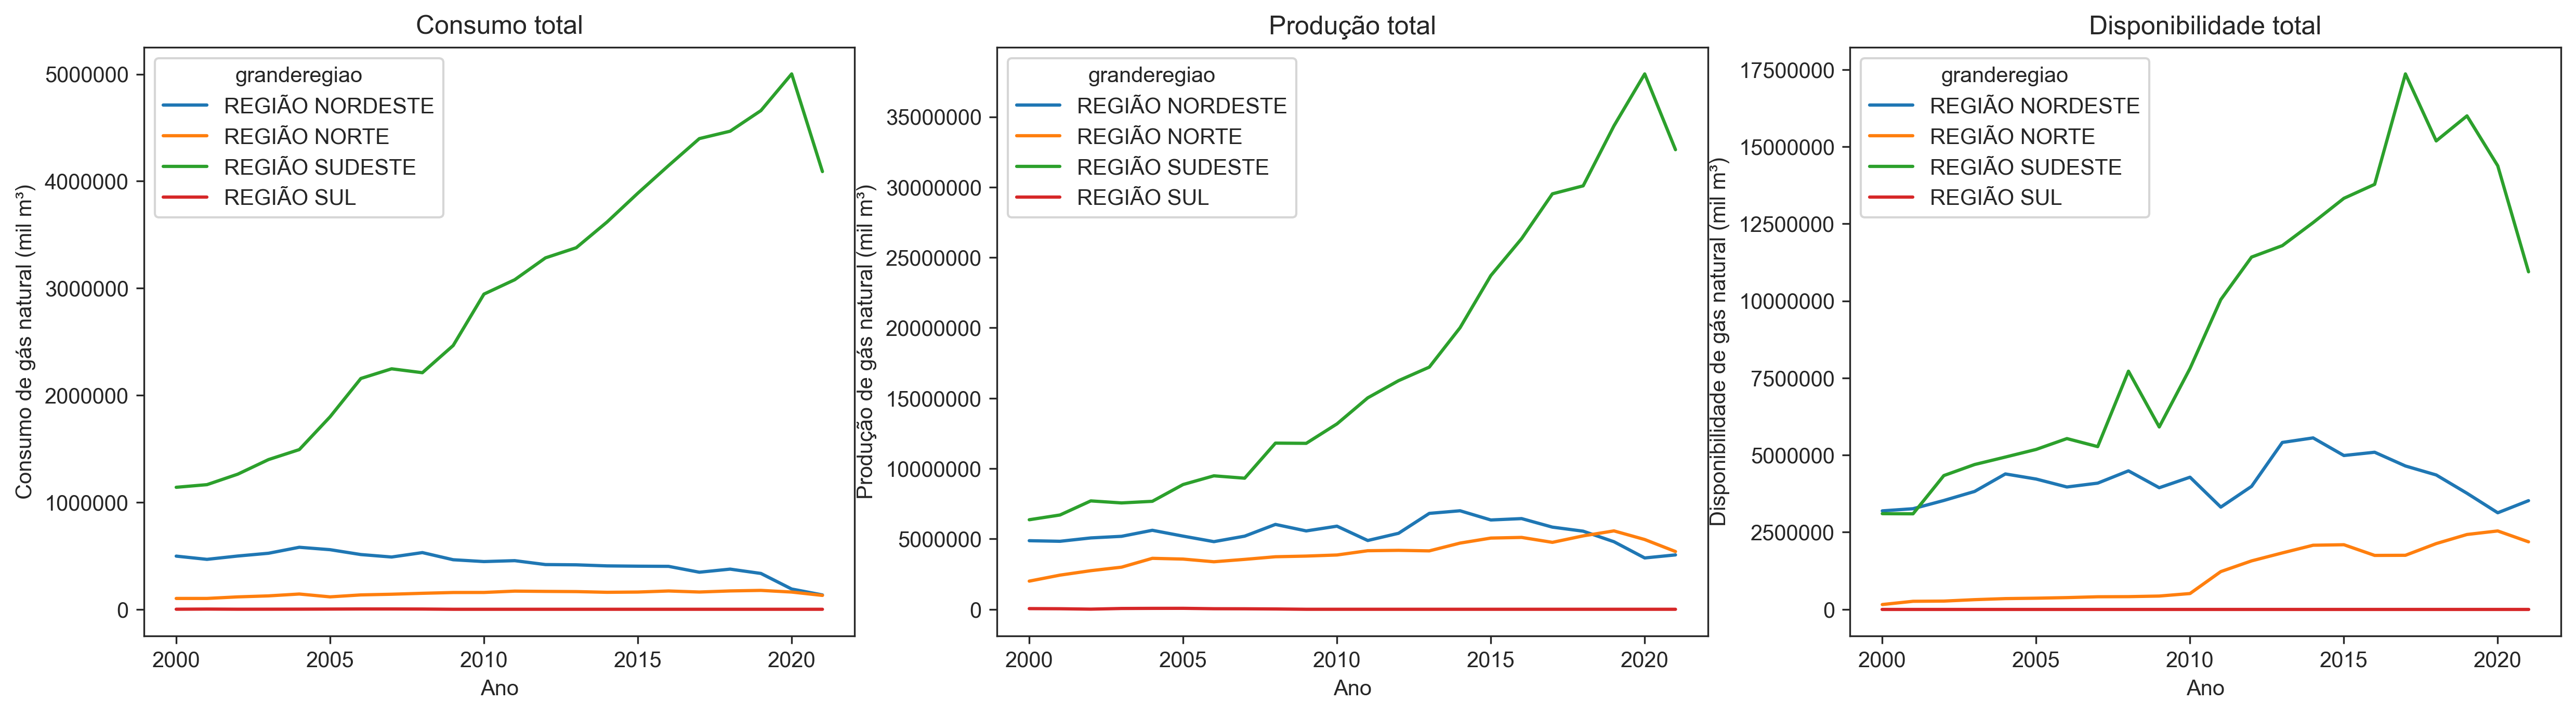

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

sns.lineplot(ax=axes[0],x="ano",y="consumo",data=soma, hue='granderegiao')
axes[0].set_title("Consumo total")
axes[0].set(xlabel='Ano', ylabel='Consumo de gás natural (mil m³)')

sns.lineplot(ax=axes[1],x="ano",y="producao",data=soma, hue='granderegiao')
axes[1].set_title("Produção total")
axes[1].set(xlabel='Ano', ylabel='Produção de gás natural (mil m³)')

sns.lineplot(ax=axes[2],x="ano",y="disponivel",data=soma, hue='granderegiao')
axes[2].set_title("Disponibilidade total")
axes[2].set(xlabel='Ano', ylabel='Disponibilidade de gás natural (mil m³)')

axes[0].ticklabel_format(style='plain', axis='y')
axes[1].ticklabel_format(style='plain', axis='y')
axes[2].ticklabel_format(style='plain', axis='y')

plt.show()

De acordo com os gráficos acima, o consumo total de cada região brasileira, com exceção do centro-oeste, entre o período de 2000 a 2021. Percebe-se houve uma variação pequena no consumo ao longo dos anos nas regiões Norte, Nordeste e Sul. É notável que a região Sudeste estava em constante crescimento até o ano de 2020, porém em 2021 podemos perceber uma queda de visivel que pode ser interpretada por conta do período de pandemia. É preciso notar, também, que para a região Sul a partir do ano de 2009, não há mais registros de para a região.

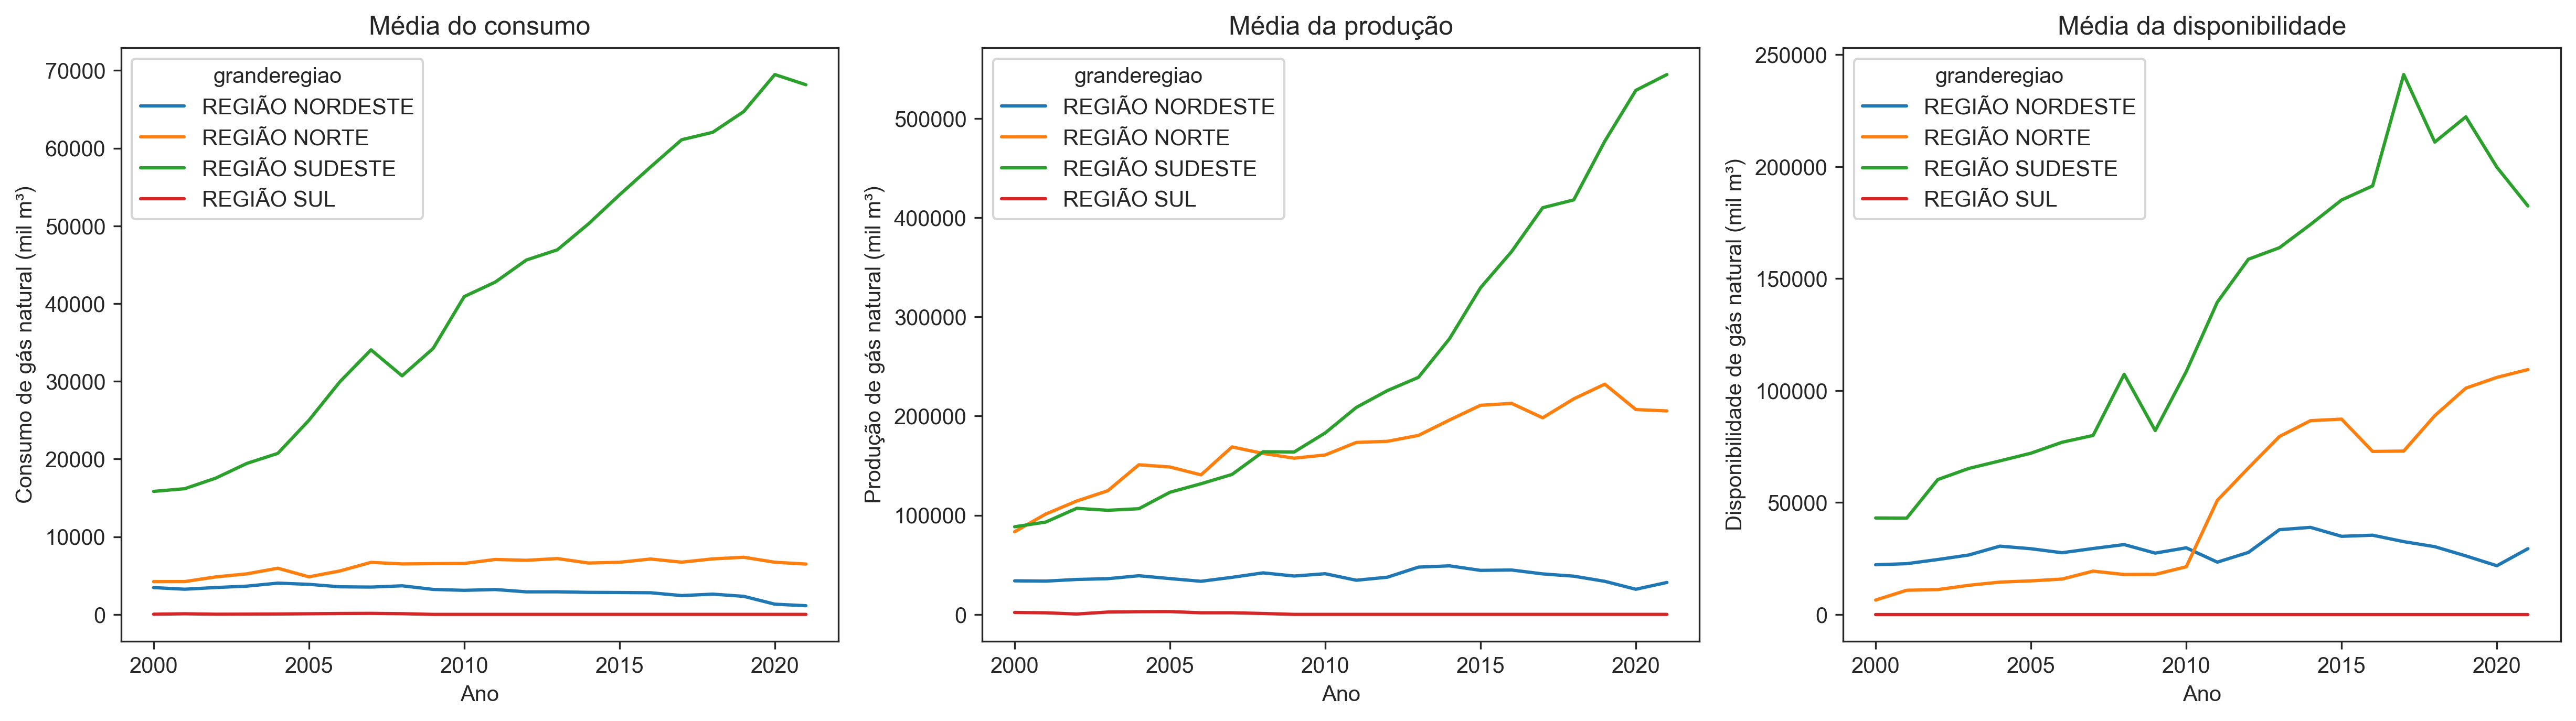

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(ax=axes[0],x="ano",y="consumo",data=media, hue='granderegiao')
axes[0].set_title("Média do consumo")
axes[0].set(xlabel='Ano', ylabel='Consumo de gás natural (mil m³)')

sns.lineplot(ax=axes[1],x="ano",y="producao",data=media, hue='granderegiao')
axes[1].set_title("Média da produção")
axes[1].set(xlabel='Ano', ylabel='Produção de gás natural (mil m³)')

sns.lineplot(ax=axes[2],x="ano",y="disponivel",data=media, hue='granderegiao')
axes[2].set_title("Média da disponibilidade")
axes[2].set(xlabel='Ano', ylabel='Disponibilidade de gás natural (mil m³)')

axes[0].ticklabel_format(style='plain', axis='y')
axes[1].ticklabel_format(style='plain', axis='y')
axes[2].ticklabel_format(style='plain', axis='y')

plt.show()

É possível perceber um aumento gradativo de produtividade na região sudeste ao longo dos anos, enquanto as regiões Norte e Nordeste apresentam estabilidade na produção. Nota-se que a produção na região Sudeste estava em crescimento até o ano de 2020, contudo, em 2021 podemos perceber uma queda que, segundo a ANP, foi motivada pela interrupção temporária da produção em alguns campos, devido aos efeitos da pandemia da COVID-19. Fica evidente, também, que para a região Sul a partir do ano de 2009, não há mais registros de produção.



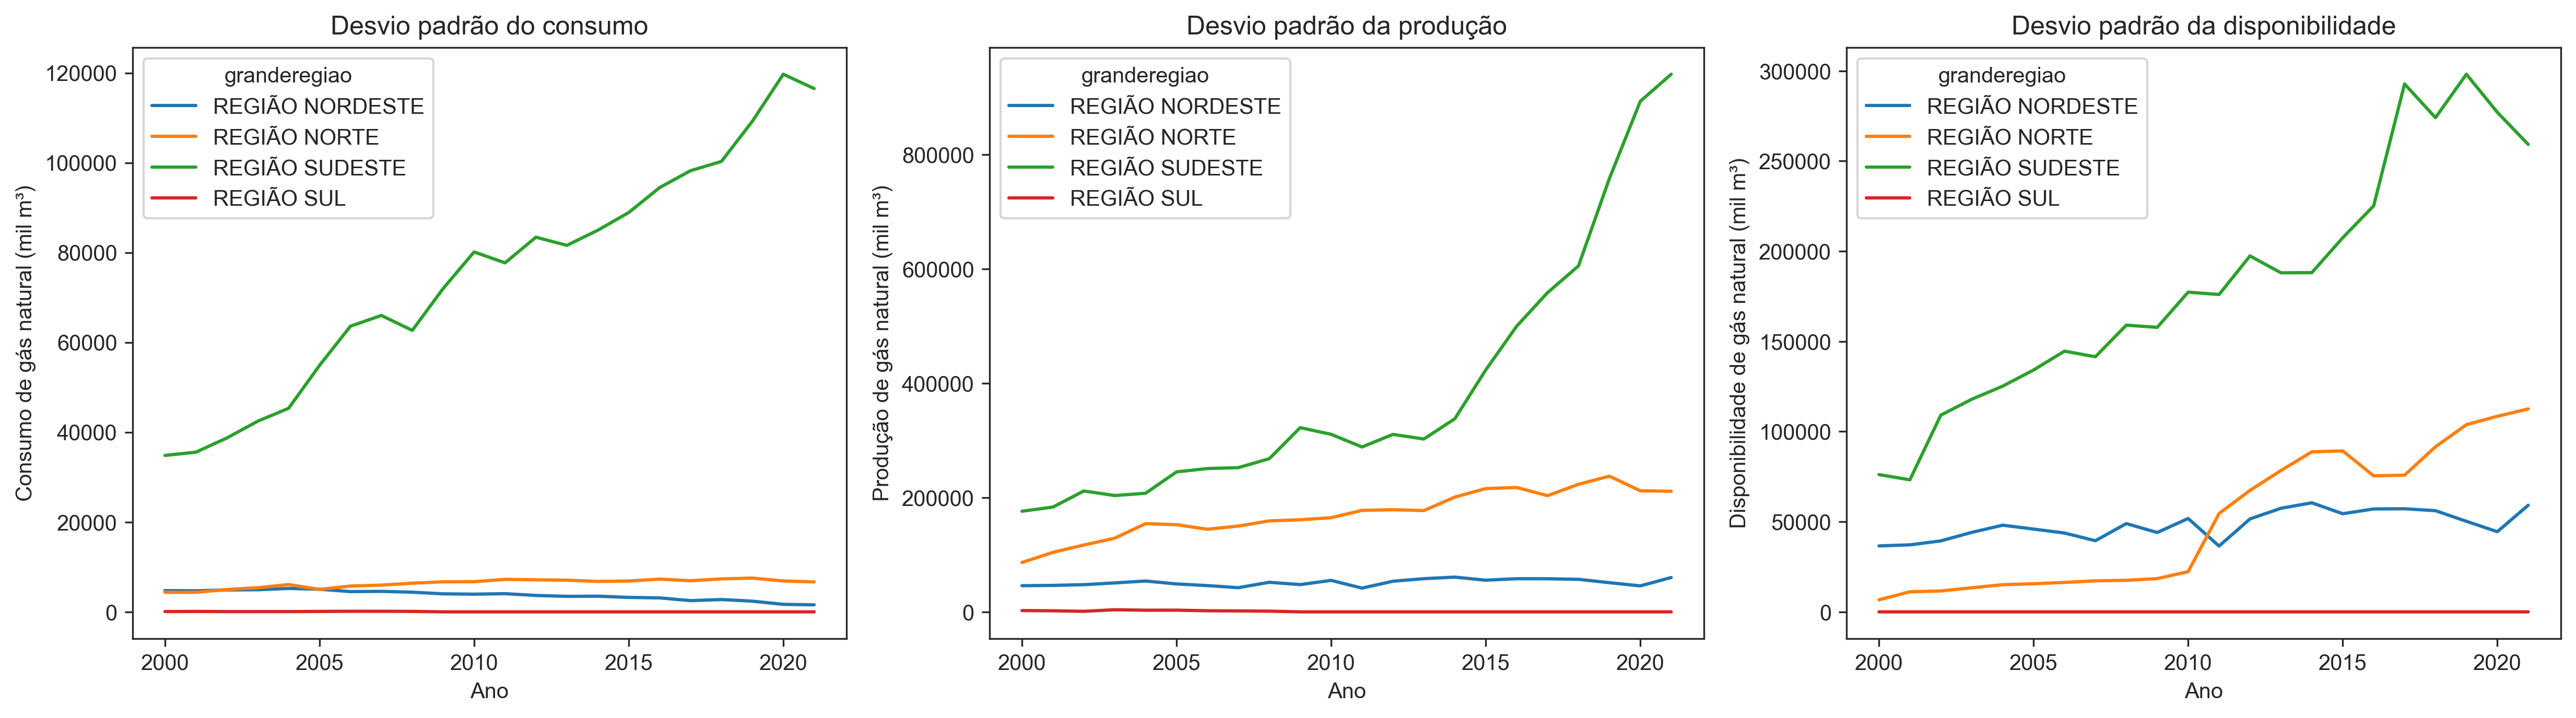

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(ax=axes[0],x="ano",y="consumo",data=desvio, hue='granderegiao')
axes[0].set_title("Desvio padrão do consumo")
axes[0].set(xlabel='Ano', ylabel='Consumo de gás natural (mil m³)')

sns.lineplot(ax=axes[1],x="ano",y="producao",data=desvio, hue='granderegiao')
axes[1].set_title("Desvio padrão da produção")
axes[1].set(xlabel='Ano', ylabel='Produção de gás natural (mil m³)')

sns.lineplot(ax=axes[2],x="ano",y="disponivel",data=desvio, hue='granderegiao')
axes[2].set_title("Desvio padrão da disponibilidade")
axes[2].set(xlabel='Ano', ylabel='Disponibilidade de gás natural (mil m³)')

axes[0].ticklabel_format(style='plain', axis='y')
axes[1].ticklabel_format(style='plain', axis='y')
axes[2].ticklabel_format(style='plain', axis='y')

plt.show()

De acordo com os gráficos de desvio padrão acima, podemos destacar que o aumento no desvio padrão na região sudeste é devido à discrepância na quantidade de Gás Natural produzido, consumido e disponível no estado do Rio de Janeiro.

In [ ]:
temp_df = df_final.query("ano > 2011").query("granderegiao == 'REGIÃO SUDESTE'").groupby(["ano","unidadedafederacao"]).mean().round(2).tail(24)
total_rj = temp_df.query("unidadedafederacao == 'RIO DE JANEIRO'").sum()
total_sp_es = temp_df.query("unidadedafederacao != 'RIO DE JANEIRO'").sum()
total_sudeste = temp_df.sum()
print(f'''No período entre 2011 e 2021 o estado do Rio de Janeiro foi responsável por:
* {round(total_rj['consumo']/total_sudeste['consumo']* 100,2)}% do consumo de Gás Natural no Sudeste
* {round(total_rj['producao']/total_sudeste['producao'] * 100,2)}% da produção de Gás Natural no Sudeste
* {round(total_rj['disponivel']/total_sudeste['disponivel']* 100,2)}% da disponibilidade de Gás Natural no Sudeste''')


No período entre 2011 e 2021 o estado do Rio de Janeiro foi responsável por:
* 77.16% do consumo de Gás Natural no Sudeste
* 68.88% da produção de Gás Natural no Sudeste
* 56.27% da disponibilidade de Gás Natural no Sudeste


In [ ]:
corr.round(2)

consumo  producao  disponivel
consumo        1.00      0.92        0.88
producao       0.92      1.00        0.93
disponivel     0.88      0.93        1.00

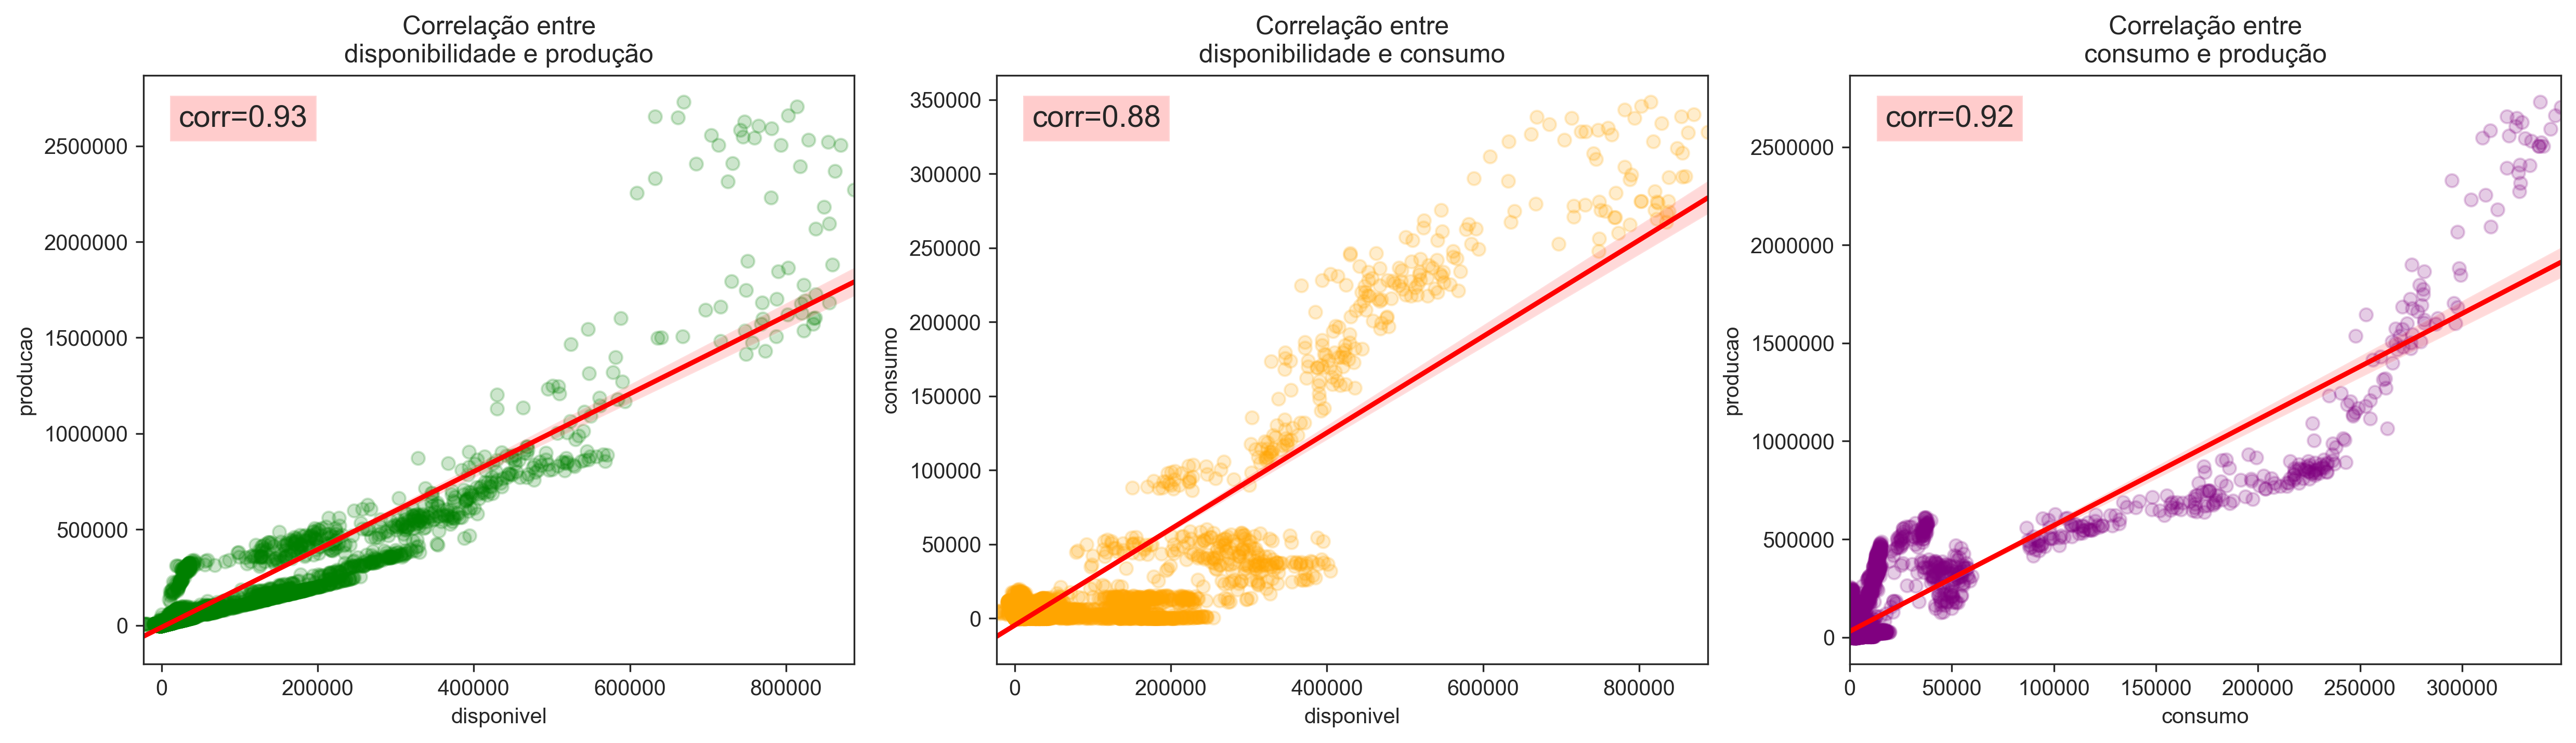

In [ ]:
corr_consumo_disp = corr['consumo'].iloc[2].round(2)
corr_consumo_prod = corr['consumo'].iloc[1].round(2)
corr_prod_disp = corr['producao'].iloc[2].round(2)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.regplot(ax=axes[0],data=df_final, x="disponivel", y="producao",
            scatter_kws={"color": "green","alpha":0.2}, line_kws={"color": "red"},scatter=True,fit_reg=True)
corr0 = f"corr={corr_prod_disp}"
axes[0].text(0.05, 0.95, corr0, transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='red', alpha=0.2))
axes[0].set_title("Correlação entre\ndisponibilidade e produção")

sns.regplot(ax=axes[1],data=df_final, x="disponivel", y="consumo",
            scatter_kws={"color": "orange","alpha":0.2}, line_kws={"color": "red"},scatter=True,fit_reg=True)
corr1 = f"corr={corr_consumo_disp}"
axes[1].text(0.05, 0.95, corr1, transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='red', alpha=0.2))
axes[1].set_title("Correlação entre\ndisponibilidade e consumo")

sns.regplot(ax=axes[2],data=df_final, x="consumo", y="producao",
            scatter_kws={"color": "purple","alpha":0.2, "label":"oi"}, line_kws={"color": "red"},scatter=True,fit_reg=True)
corr2 = f"corr={corr_consumo_prod}"
axes[2].text(0.05, 0.95, corr2, transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(facecolor='red', alpha=0.2))
axes[2].set_title("Correlação entre\nconsumo e produção")

axes[0].ticklabel_format(style='plain', axis='y')
axes[1].ticklabel_format(style='plain', axis='y')
axes[2].ticklabel_format(style='plain', axis='y')


plt.show()

Conforme os gráficos de correlação acima, é possível observar o nível de confiabilidade dos dados, pois os datasets apresentam altos índices de correlação. O índice menor para a correlação entre disponibilidade e consumo pode estar relacionado com a influência de outras variáveis como injeção e queima de gás natural, e também a importação de gás natural de outros países.

Agrupando os dados em diferentes *DataFrames*, um para cada região

In [ ]:
grouped = df_final.groupby(df_final.granderegiao)
nordeste_dados = grouped.get_group("REGIÃO NORDESTE")
norte_dados = grouped.get_group("REGIÃO NORTE")
sudeste_dados = grouped.get_group("REGIÃO SUDESTE")
sul_dados = grouped.get_group("REGIÃO SUL")

In [ ]:
nordeste_dados

ano  mes     granderegiao   unidadedafederacao      produto  \
0     2000  AGO  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL   
1     2000  SET  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL   
2     2000  JUN  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL   
3     2000  JUL  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL   
4     2000  DEZ  REGIÃO NORDESTE  RIO GRANDE DO NORTE  GÁS NATURAL   
...    ...  ...              ...                  ...          ...   
5718  2021  JAN  REGIÃO NORDESTE                BAHIA  GÁS NATURAL   
5719  2021  OUT  REGIÃO NORDESTE              SERGIPE  GÁS NATURAL   
5720  2021  SET  REGIÃO NORDESTE              SERGIPE  GÁS NATURAL   
5721  2021  SET  REGIÃO NORDESTE                BAHIA  GÁS NATURAL   
5731  2021  OUT  REGIÃO NORDESTE                BAHIA  GÁS NATURAL   

     localizacao  consumo  producao  disponivel datacompleta mes_numerico  
0            MAR 4,344.21 75,850.51   40,493.71   2000/08/01           08  
1            MAR 5,063.35 70,891.20   33,923.55   2000/09/01           09  
2            MAR 4,845.85 73,282.75   36,890.90   2000/06/01           06  
3            MAR 5,175.34 74,975.48   35,342.44   2000/07/01           07  
4            MAR 4,709.74 76,444.36   42,537.32   2000/12/01           12  
...          ...      ...       ...         ...          ...          ...  
5718       TERRA 3,584.20 65,577.38   44,850.73   2021/01/01           01  
5719       TERRA   850.32  1,361.36       -0.09   2021/10/01           10  
5720       TERRA   734.76  1,210.80       -0.09   2021/09/01           09  
5721       TERRA 3,568.11 66,075.12   45,387.80   2021/09/01           09  
5731       TERRA 3,766.84 71,599.10   51,650.21   2021/10/01           10  

[3133 rows x 11 columns]

In [ ]:
nordeste_2008 = nordeste_dados.query("ano == 2008").groupby(["unidadedafederacao",'ano']).mean().round(2)
nordeste_2016 = nordeste_dados.query("ano == 2016").groupby(["unidadedafederacao",'ano']).mean().round(2)
nordeste_2021 = nordeste_dados.query("ano == 2021").groupby(["unidadedafederacao",'ano']).mean().round(2)


In [ ]:
#mapa do nordeste
nordeste

nome sigla geocodigo  \
4               Sergipe    SE        28   
5               Alagoas    AL        27   
12                Piauí    PI        22   
13              Paraíba    PB        25   
14                Ceará    CE        23   
20                Bahia    BA        29   
22           Pernambuco    PE        26   
23  Rio Grande do Norte    RN        24   
24             Maranhão    MA        21   

                                             geometry     granderegiao  
4   MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ...  REGIÃO NORDESTE  
5   MULTIPOLYGON (((-35.45878 -8.81780, -35.45898 ...  REGIÃO NORDESTE  
12  MULTIPOLYGON (((-41.73344 -2.81111, -41.73205 ...  REGIÃO NORDESTE  
13  MULTIPOLYGON (((-37.21443 -6.03725, -37.20704 ...  REGIÃO NORDESTE  
14  MULTIPOLYGON (((-40.42389 -2.81130, -40.41525 ...  REGIÃO NORDESTE  
20  MULTIPOLYGON (((-38.97119 -8.78270, -38.95972 ...  REGIÃO NORDESTE  
22  MULTIPOLYGON (((-32.38846 -3.81629, -32.39054 ...  REGIÃO NORDESTE  
23  MULTIPOLYGON (((-35.20267 -5.74677, -35.20324 ...  REGIÃO NORDESTE  
24  MULTIPOLYGON (((-42.03760 -2.70322, -42.04097 ...  REGIÃO NORDESTE

In [ ]:
nordeste_2008.reset_index(inplace=True)
nordeste_2016.reset_index(inplace=True)
nordeste_2021.reset_index(inplace=True)

#Arquivo do GPD com o mapa do nordeste
nordeste.reset_index(inplace=True)

In [ ]:
nordeste = nordeste.drop(columns=["index"])

In [ ]:
nordeste_2008 = nordeste_2008.rename(columns={"unidadedafederacao":"nome"})
nordeste_2016 = nordeste_2016.rename(columns={"unidadedafederacao":"nome"})
nordeste_2021 = nordeste_2021.rename(columns={"unidadedafederacao":"nome"})

In [ ]:
for idx,_ in enumerate(nordeste["nome"]):
    nordeste.at[idx, "nome"] = nordeste.at[idx, "nome"].upper()

In [ ]:
nordeste

nome sigla geocodigo  \
0              SERGIPE    SE        28   
1              ALAGOAS    AL        27   
2                PIAUÍ    PI        22   
3              PARAÍBA    PB        25   
4                CEARÁ    CE        23   
5                BAHIA    BA        29   
6           PERNAMBUCO    PE        26   
7  RIO GRANDE DO NORTE    RN        24   
8             MARANHÃO    MA        21   

                                            geometry     granderegiao  
0  MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ...  REGIÃO NORDESTE  
1  MULTIPOLYGON (((-35.45878 -8.81780, -35.45898 ...  REGIÃO NORDESTE  
2  MULTIPOLYGON (((-41.73344 -2.81111, -41.73205 ...  REGIÃO NORDESTE  
3  MULTIPOLYGON (((-37.21443 -6.03725, -37.20704 ...  REGIÃO NORDESTE  
4  MULTIPOLYGON (((-40.42389 -2.81130, -40.41525 ...  REGIÃO NORDESTE  
5  MULTIPOLYGON (((-38.97119 -8.78270, -38.95972 ...  REGIÃO NORDESTE  
6  MULTIPOLYGON (((-32.38846 -3.81629, -32.39054 ...  REGIÃO NORDESTE  
7  MULTIPOLYGON (((-35.20267 -5.74677, -35.20324 ...  REGIÃO NORDESTE  
8  MULTIPOLYGON (((-42.03760 -2.70322, -42.04097 ...  REGIÃO NORDESTE

In [ ]:
mapa_nordeste_2008 = nordeste.merge(nordeste_2008,on=["nome"],how="left")
mapa_nordeste_2016 = nordeste.merge(nordeste_2016,on=["nome"],how="left")
mapa_nordeste_2021 = nordeste.merge(nordeste_2021,on=["nome"],how="left")

In [ ]:
mapa_nordeste_2008['consumo'].fillna(0,inplace=True)
mapa_nordeste_2008['producao'].fillna(0,inplace=True)
mapa_nordeste_2008['disponivel'].fillna(0,inplace=True)
mapa_nordeste_2008['ano'].fillna(2008,inplace=True)
mapa_nordeste_2016['consumo'].fillna(0,inplace=True)
mapa_nordeste_2016['producao'].fillna(0,inplace=True)
mapa_nordeste_2016['disponivel'].fillna(0,inplace=True)
mapa_nordeste_2021['ano'].fillna(2016,inplace=True)
mapa_nordeste_2021['consumo'].fillna(0,inplace=True)
mapa_nordeste_2021['producao'].fillna(0,inplace=True)
mapa_nordeste_2021['disponivel'].fillna(0,inplace=True)
mapa_nordeste_2021['ano'].fillna(2016,inplace=True)

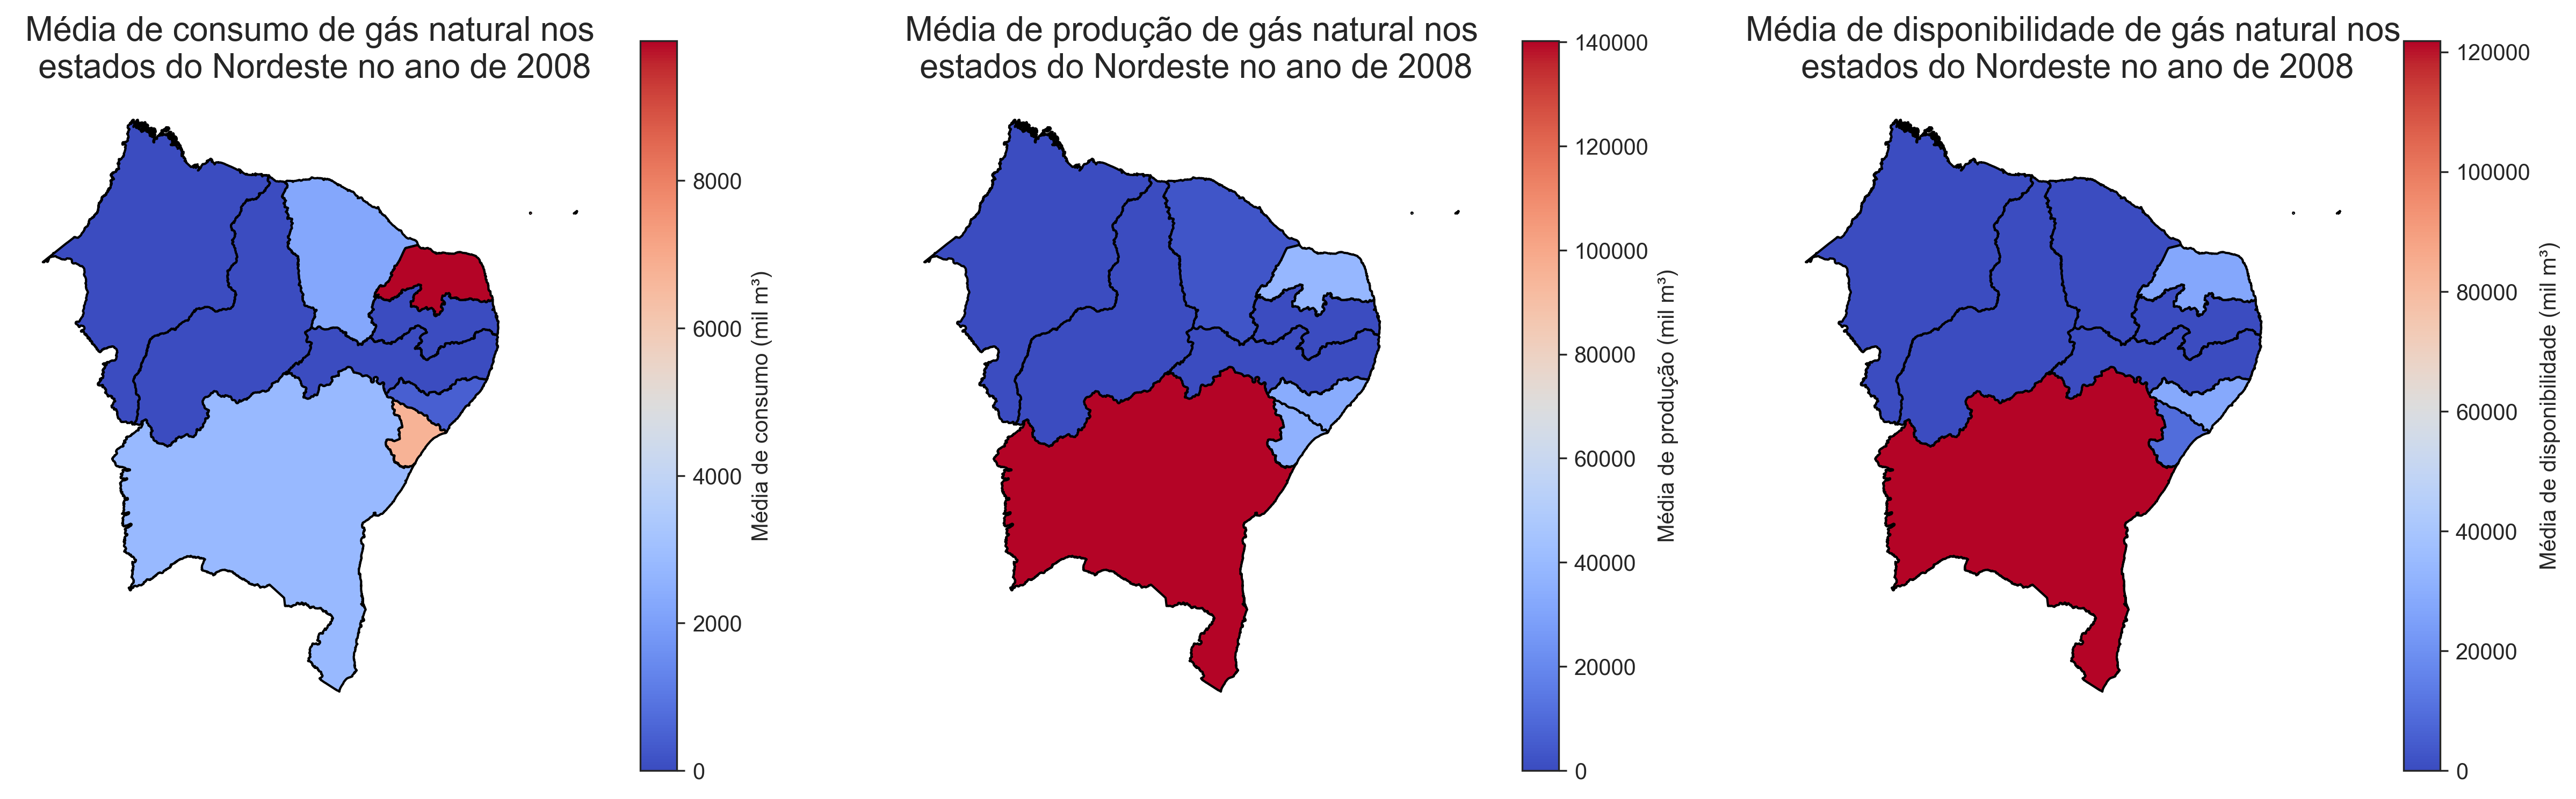

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

mapa_nordeste_2008.plot(column = 'consumo',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[0],
                        legend_kwds={'label': "Média de consumo (mil m³)"}).set_axis_off()

axes[0].set_title("Média de consumo de gás natural nos\n estados do Nordeste no ano de 2008", fontdict={"fontsize":15})
mapa_nordeste_2008.plot(column = 'producao',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[1],
                        legend_kwds={'label': "Média de produção (mil m³)"}).set_axis_off()

axes[1].set_title("Média de produção de gás natural nos\n estados do Nordeste no ano de 2008", fontdict={"fontsize":15})
mapa_nordeste_2008.plot(column = 'disponivel',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[2],
                        legend_kwds={'label': "Média de disponibilidade (mil m³)"}).set_axis_off()
axes[2].set_title("Média de disponibilidade de gás natural nos\n estados do Nordeste no ano de 2008", fontdict={"fontsize":15})
plt.show()

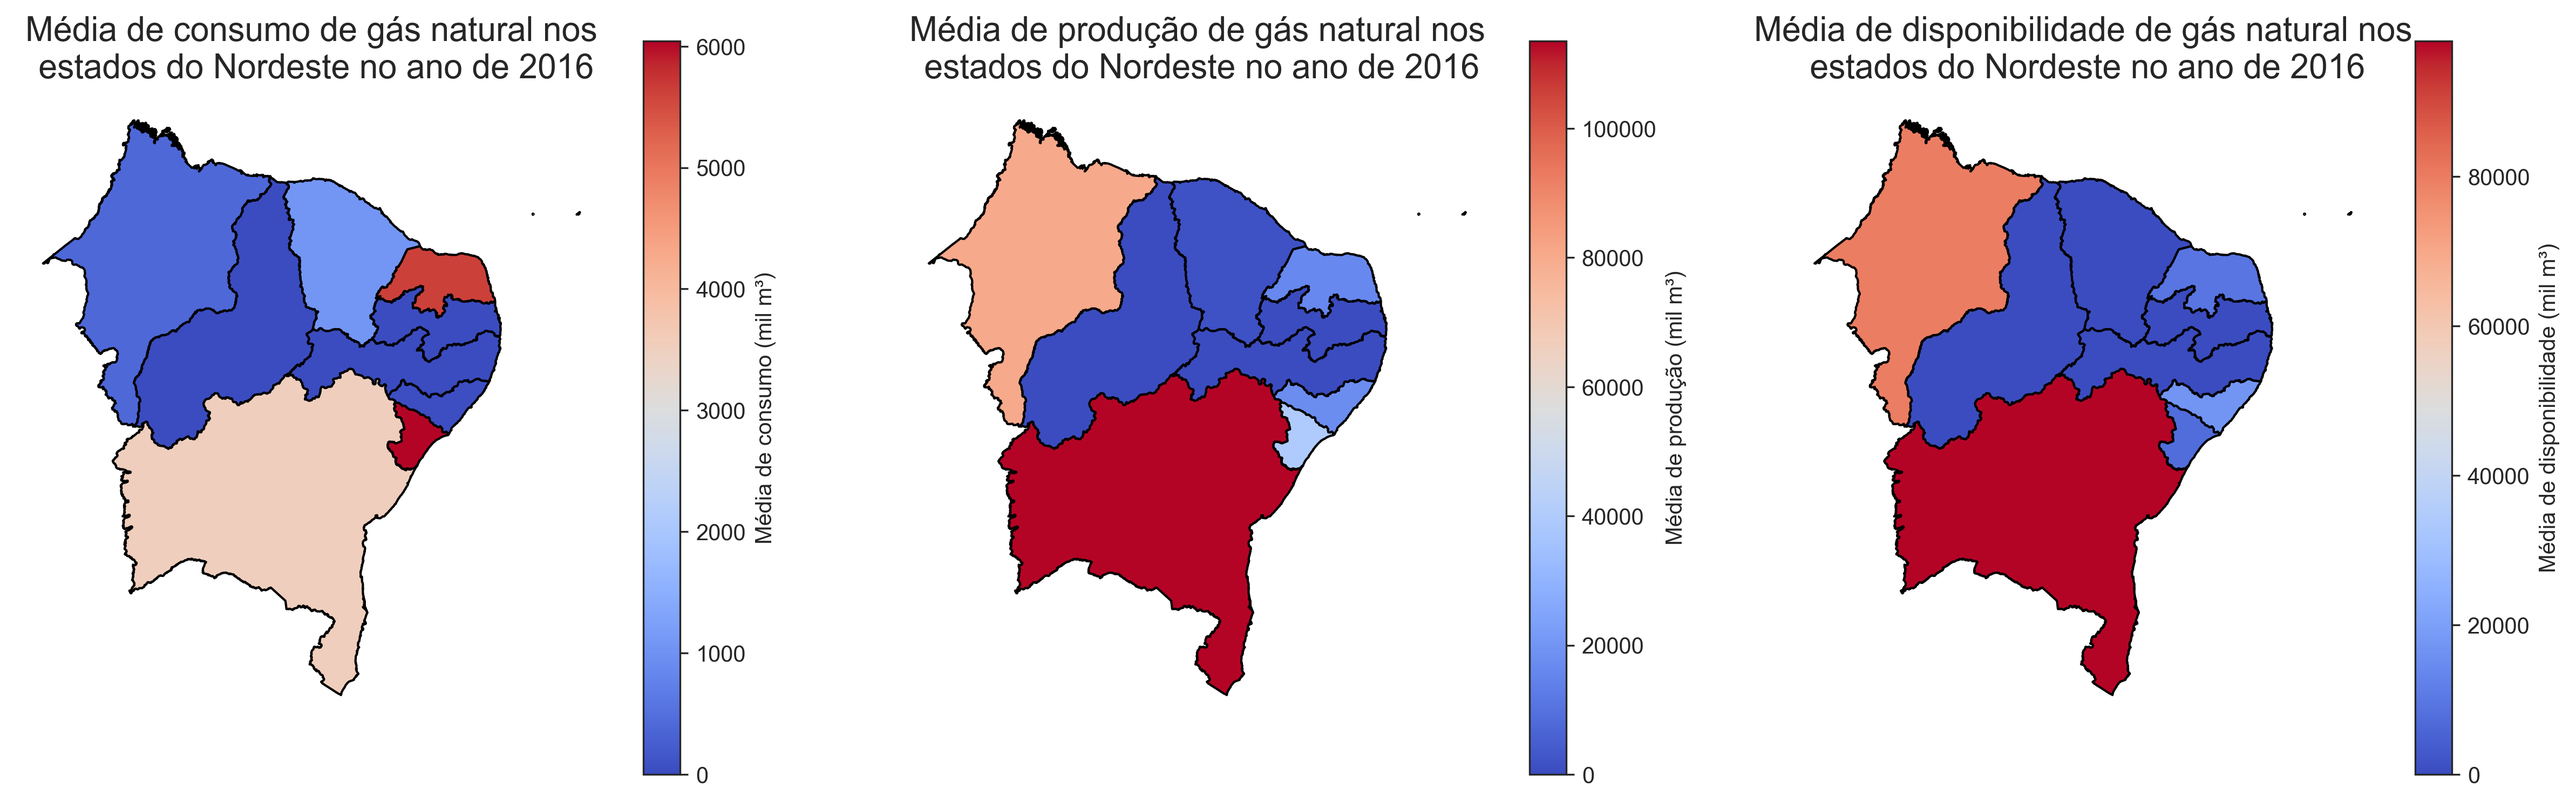

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

mapa_nordeste_2016.plot(column = 'consumo',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[0],
                        legend_kwds={'label': "Média de consumo (mil m³)"}).set_axis_off()

axes[0].set_title("Média de consumo de gás natural nos\n estados do Nordeste no ano de 2016", fontdict={"fontsize":15})
mapa_nordeste_2016.plot(column = 'producao',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[1],
                        legend_kwds={'label': "Média de produção (mil m³)"}).set_axis_off()

axes[1].set_title("Média de produção de gás natural nos\n estados do Nordeste no ano de 2016", fontdict={"fontsize":15})
mapa_nordeste_2016.plot(column = 'disponivel',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[2],
                        legend_kwds={'label': "Média de disponibilidade (mil m³)"}).set_axis_off()
axes[2].set_title("Média de disponibilidade de gás natural nos\n estados do Nordeste no ano de 2016", fontdict={"fontsize":15})
plt.show()

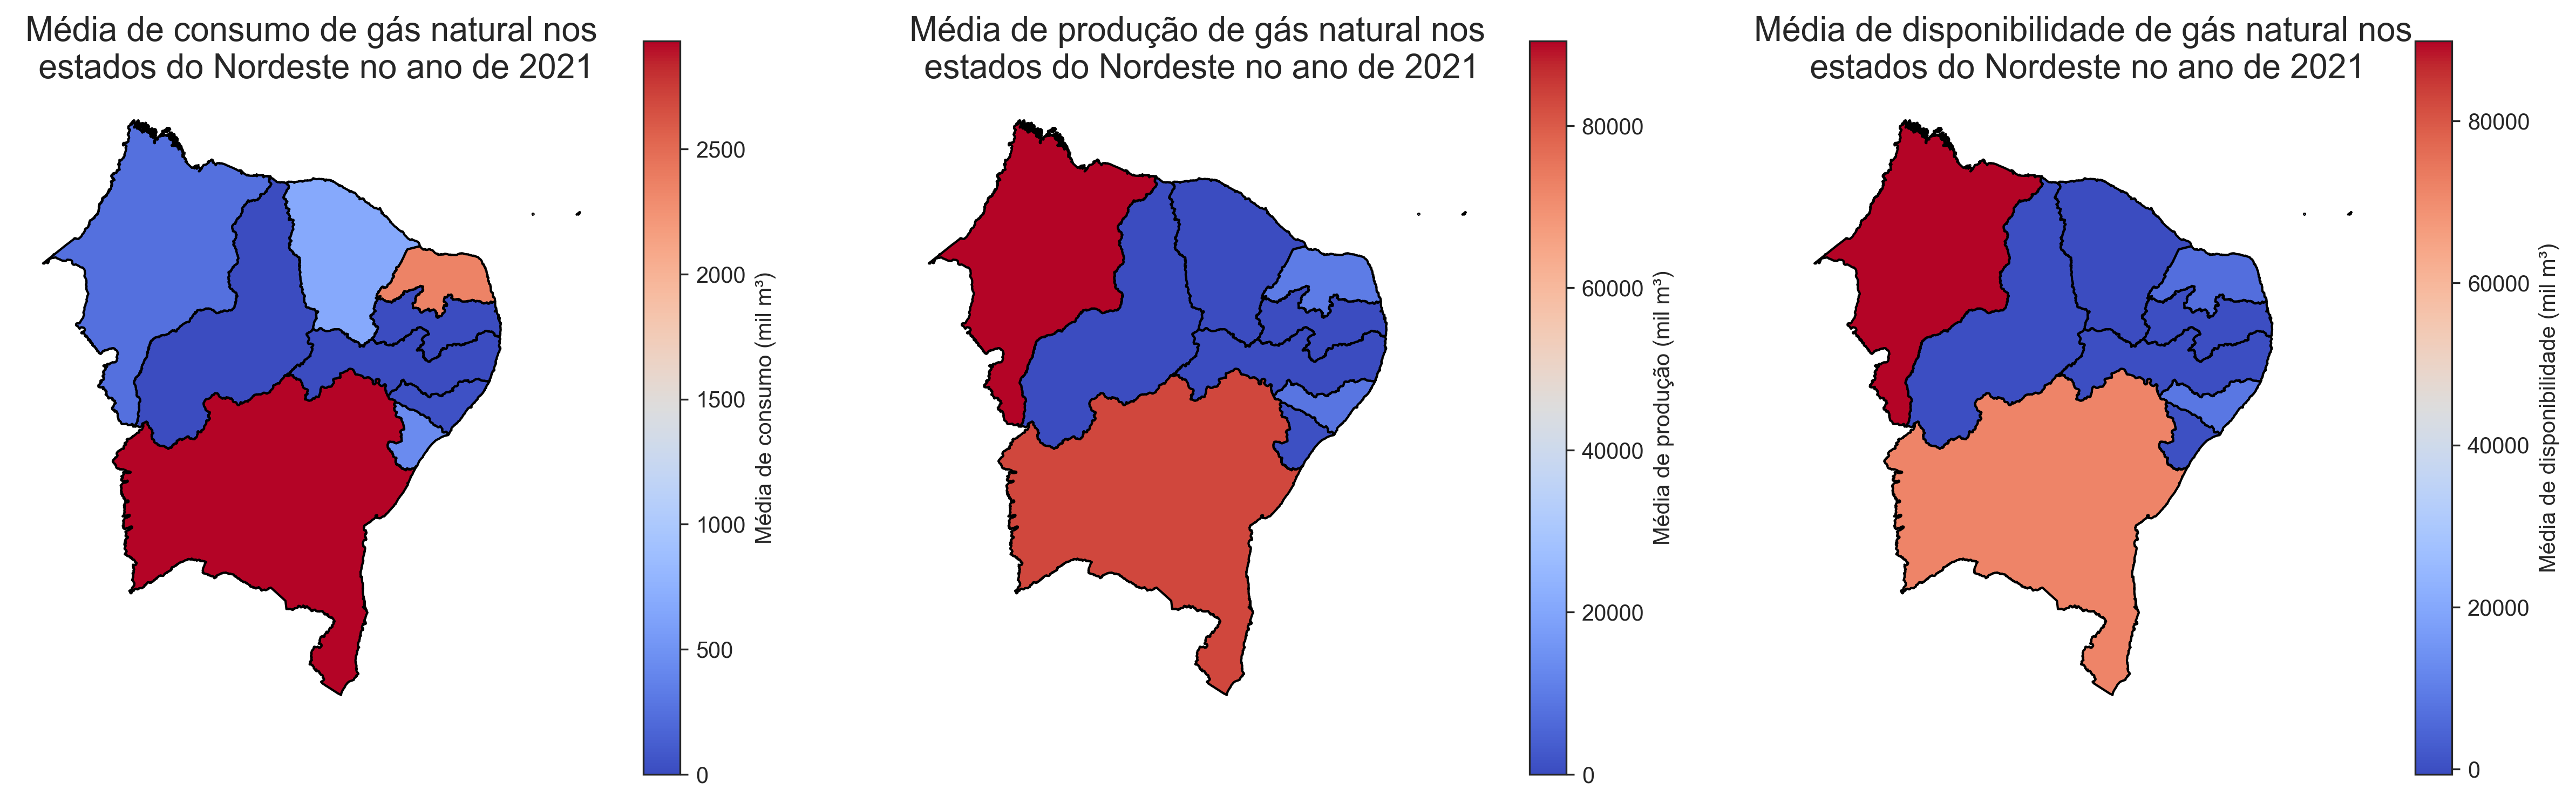

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

mapa_nordeste_2021.plot(column = 'consumo',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[0],
                        legend_kwds={'label': "Média de consumo (mil m³)"}).set_axis_off()

axes[0].set_title("Média de consumo de gás natural nos\n estados do Nordeste no ano de 2021", fontdict={"fontsize":15})
mapa_nordeste_2021.plot(column = 'producao',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[1],
                        legend_kwds={'label': "Média de produção (mil m³)"}).set_axis_off()

axes[1].set_title("Média de produção de gás natural nos\n estados do Nordeste no ano de 2021", fontdict={"fontsize":15})
mapa_nordeste_2021.plot(column = 'disponivel',cmap="coolwarm",
                        legend = True,edgecolor = 'black',
                        ax=axes[2],
                        legend_kwds={'label': "Média de disponibilidade (mil m³)"}).set_axis_off()
axes[2].set_title("Média de disponibilidade de gás natural nos\n estados do Nordeste no ano de 2021", fontdict={"fontsize":15})
plt.show()

A partir da análise dos heatmaps gerados, é possível perceber uma estabilidade na produção e disponibilidade de gás natural no nordeste. Em contrapartida, o consumo de gás natural no nordeste apresentou queda ao longo dos anos. Em resumo, a região nordeste apresenta grande potencial de produção de gás natural, no entanto, o consumo deste insumo na região ainda é pequeno.

## Regressão linear utilizando os dados de cada primeiro dia do mês disponível

Primeiramente, agrupamos, por meio da média, todos os dados dos estados do Nordeste:

In [ ]:
nordeste_dados['ano'].astype("object")
nordeste_dados_media = nordeste_dados.groupby(["datacompleta"]).mean().reset_index()
nordeste_dados_media

datacompleta  consumo  producao  disponivel
0     2000/01/01 3,399.97 33,970.70   22,746.06
1     2000/02/01 3,281.04 30,455.70   18,626.04
2     2000/03/01 3,552.09 33,579.50   21,775.66
3     2000/04/01 3,268.08 32,513.06   21,527.17
4     2000/05/01 3,385.61 34,321.46   23,093.61
..           ...      ...       ...         ...
257   2021/06/01 1,098.66 35,834.71   33,028.49
258   2021/07/01 1,152.38 36,576.12   33,815.21
259   2021/08/01 1,245.69 37,855.00   34,947.06
260   2021/09/01 1,230.80 35,872.66   32,851.42
261   2021/10/01 1,098.84 38,011.63   34,952.06

[262 rows x 4 columns]

É necessário que seja removido o caractere "/" da coluna `datacompleta` pois ela precisará ser interpretada como um número inteiro, para que seja possível realizar a Regressão Linear

In [ ]:
nordeste_dados_media["datacompleta"] = nordeste_dados_media["datacompleta"].apply(lambda x:x.replace('/',''))

Então separamos os dados para as médias do consumo, produção e disponibilidade em 3 *DataFrames* individuais

In [ ]:
media_consumo = nordeste_dados_media.drop(columns=["producao","disponivel"])
media_prod = nordeste_dados_media.drop(columns=["consumo","disponivel"])
media_disp = nordeste_dados_media.drop(columns=["producao","consumo"])

A Regressão Linear necessita de um valor X, que será o valor dos dados que serão fornecidos para treinar o algoritmo e um valor Y que será o tipo do valor que deseja predizer, no nosso caso o valor para X será sempre uma data, e o valor Y será a métrica que estamos avaliando (consumo, produção e disponibilidade)

In [ ]:
x_cons = media_consumo[["datacompleta"]].values
x_prod = media_prod[["datacompleta"]].values
x_disp = media_disp[["datacompleta"]].values

y_cons = media_consumo["consumo"].values
y_prod = media_prod["producao"].values
y_disp = media_disp["disponivel"].values

Os dados então são separados para o treino do algoritmo

In [ ]:
x_cons_train, x_cons_test, y_cons_train, y_cons_test = train_test_split(x_cons, y_cons, test_size=0.33)
x_prod_train, x_prod_test, y_prod_train, y_prod_test = train_test_split(x_prod, y_prod, test_size=0.33)
x_disp_train, x_disp_test, y_disp_train, y_disp_test = train_test_split(x_disp, y_disp, test_size=0.33)

Abaixo inciamos um objeto do tipo `LinearRegression`, que é o nosso algoritmo escolhido para predição, e é realizado o treinamento do algoritmo através do método `.fit()` passando nosos dados selecionados para o treino

In [ ]:
reg_cons = linear_model.LinearRegression()
reg_cons.fit(x_cons_train, y_cons_train)
reg_prod = linear_model.LinearRegression()
reg_prod.fit(x_prod_train, y_prod_train)
reg_disp = linear_model.LinearRegression()
reg_disp.fit(x_disp_train, y_disp_train)

LinearRegression()

Criando nossas variáveis

In [ ]:
df_pred = pd.DataFrame() #DataFrame que irá receber nossos dados de predição
ano_mes_dia = [] #lista que irá receber a data completa
valor_cons_predict = [] #lista que irá receber o array c/ os valores do algoritmo para consumo
valor_prod_predict = [] #lista que irá receber o array c/ os valores do algoritmo para produção
valor_disp_predict = [] #lista que irá receber o array c/ os valores do algoritmo para disponibilidade
anos = [] #lista que irá receber o valor para os anos (2022-2032)
meses = [] #lista que irá receber o valor para os meses (1-12)

#as três listas a seguir irão receber o valores contidos na suas respectivas listas de predição
consumos = []
producoes = []
disponiveis = []

Populando o DataFrame de predição (`df_pred`)

In [ ]:
#gerando as datas
for i in range(2022,2033):
    for j in range(1,13):
        if j < 10:
            ano_mes_dia.append([str(i)+"0"+str(j)+"01"])
        else:
            ano_mes_dia.append([str(i)+str(j)+"01"])

#separando as datas em anos e meses, pois só iremos analisar os valores para
#o primeiro dia de cada mês entre 01/01/2022 e 01/12/2032
for data in ano_mes_dia:
    anos.append(data[0][0:4])
    meses.append(data[0][4:6])

#convertendo a data completa para uum número inteiro, que será usado para
#prever os valores
for i in range(len(ano_mes_dia)):
    ano_mes_dia[i][0] = int(ano_mes_dia[i][0])

#realizando a predição para o primeiro dia de cada mês entre 01/01/2022 e 01/12/2032
for data in ano_mes_dia:
    valor_cons_predict.append(reg_cons.predict([data]))
    valor_prod_predict.append(reg_prod.predict([data]))
    valor_disp_predict.append(reg_disp.predict([data]))

#criando a coluna de ano e mes para o dataframe
df_pred["ano"] = anos
df_pred["mes_numerico"] = meses

#populando as respectivas listas com os valores preditos para todos os primeiros dias
#de cada mês até 2032
for consumo in valor_cons_predict:
    consumos.append(consumo[0])
for prod in valor_prod_predict:
    producoes.append(prod[0])
for disp in valor_disp_predict:
    disponiveis.append(disp[0])
df_pred["consumo"] = consumos
df_pred["producao"] = producoes
df_pred["disponivel"] = disponiveis

Por fim, temos o seguinte *DataFrame*:

In [ ]:
df_pred

ano mes_numerico  consumo  producao  disponivel
0    2022           01 2,033.45 37,780.12   32,126.17
1    2022           02 2,032.57 37,780.36   32,128.86
2    2022           03 2,031.69 37,780.60   32,131.55
3    2022           04 2,030.80 37,780.84   32,134.24
4    2022           05 2,029.92 37,781.08   32,136.93
..    ...          ...      ...       ...         ...
127  2032           08 1,146.16 38,020.24   34,834.27
128  2032           09 1,145.28 38,020.48   34,836.96
129  2032           10 1,144.40 38,020.71   34,839.65
130  2032           11 1,143.52 38,020.95   34,842.34
131  2032           12 1,142.64 38,021.19   34,845.03

[132 rows x 5 columns]

In [ ]:
#média para cada ano
media_pred = df_pred.groupby(["ano"]).mean().reset_index()
media_pred

ano  consumo  producao  disponivel
0   2022 2,028.60 37,781.44   32,140.96
1   2023 1,940.49 37,805.28   32,409.89
2   2024 1,852.38 37,829.12   32,678.82
3   2025 1,764.27 37,852.97   32,947.75
4   2026 1,676.15 37,876.81   33,216.67
5   2027 1,588.04 37,900.66   33,485.60
6   2028 1,499.93 37,924.50   33,754.53
7   2029 1,411.82 37,948.35   34,023.46
8   2030 1,323.71 37,972.19   34,292.38
9   2031 1,235.60 37,996.03   34,561.31
10  2032 1,147.48 38,019.88   34,830.24

Agrupamos então os dados disponibilizados pela ANP com os dados gerados através da regressão linear, em um só *DataFrame* para que seja possível desenhar um gráfico em relação ao ano das médias do consumo, produção e disponibilidade entre o período de 2000 até 2032

In [ ]:
media_nordeste = media.query("granderegiao == 'REGIÃO NORDESTE'").reset_index().drop(columns=["index","granderegiao"])

In [ ]:
media_nordeste

ano  consumo  producao  disponivel
0   2000 3,449.38 33,841.40   22,161.13
1   2001 3,239.75 33,555.27   22,646.79
2   2002 3,455.98 35,212.20   24,499.45
3   2003 3,635.36 36,009.34   26,534.09
4   2004 4,023.54 38,978.25   30,476.72
5   2005 3,866.99 36,099.48   29,326.15
6   2006 3,551.49 33,378.27   27,538.35
7   2007 3,513.31 37,383.07   29,426.20
8   2008 3,678.26 41,879.05   31,173.55
9   2009 3,214.83 38,675.37   27,371.63
10  2010 3,095.87 41,008.75   29,741.40
11  2011 3,199.52 34,421.03   23,329.41
12  2012 2,901.60 37,495.89   27,680.24
13  2013 2,904.78 47,657.11   37,832.01
14  2014 2,834.84 48,954.50   38,862.22
15  2015 2,815.63 44,379.27   34,869.50
16  2016 2,785.54 44,751.65   35,364.31
17  2017 2,421.75 40,824.93   32,495.24
18  2018 2,605.49 38,540.05   30,246.87
19  2019 2,325.40 33,340.98   26,124.52
20  2020 1,314.32 25,330.56   21,731.02
21  2021 1,116.27 32,204.70   29,349.21

In [ ]:
media_nordeste_atual_pred = pd.concat([media_nordeste, media_pred], ignore_index=True)

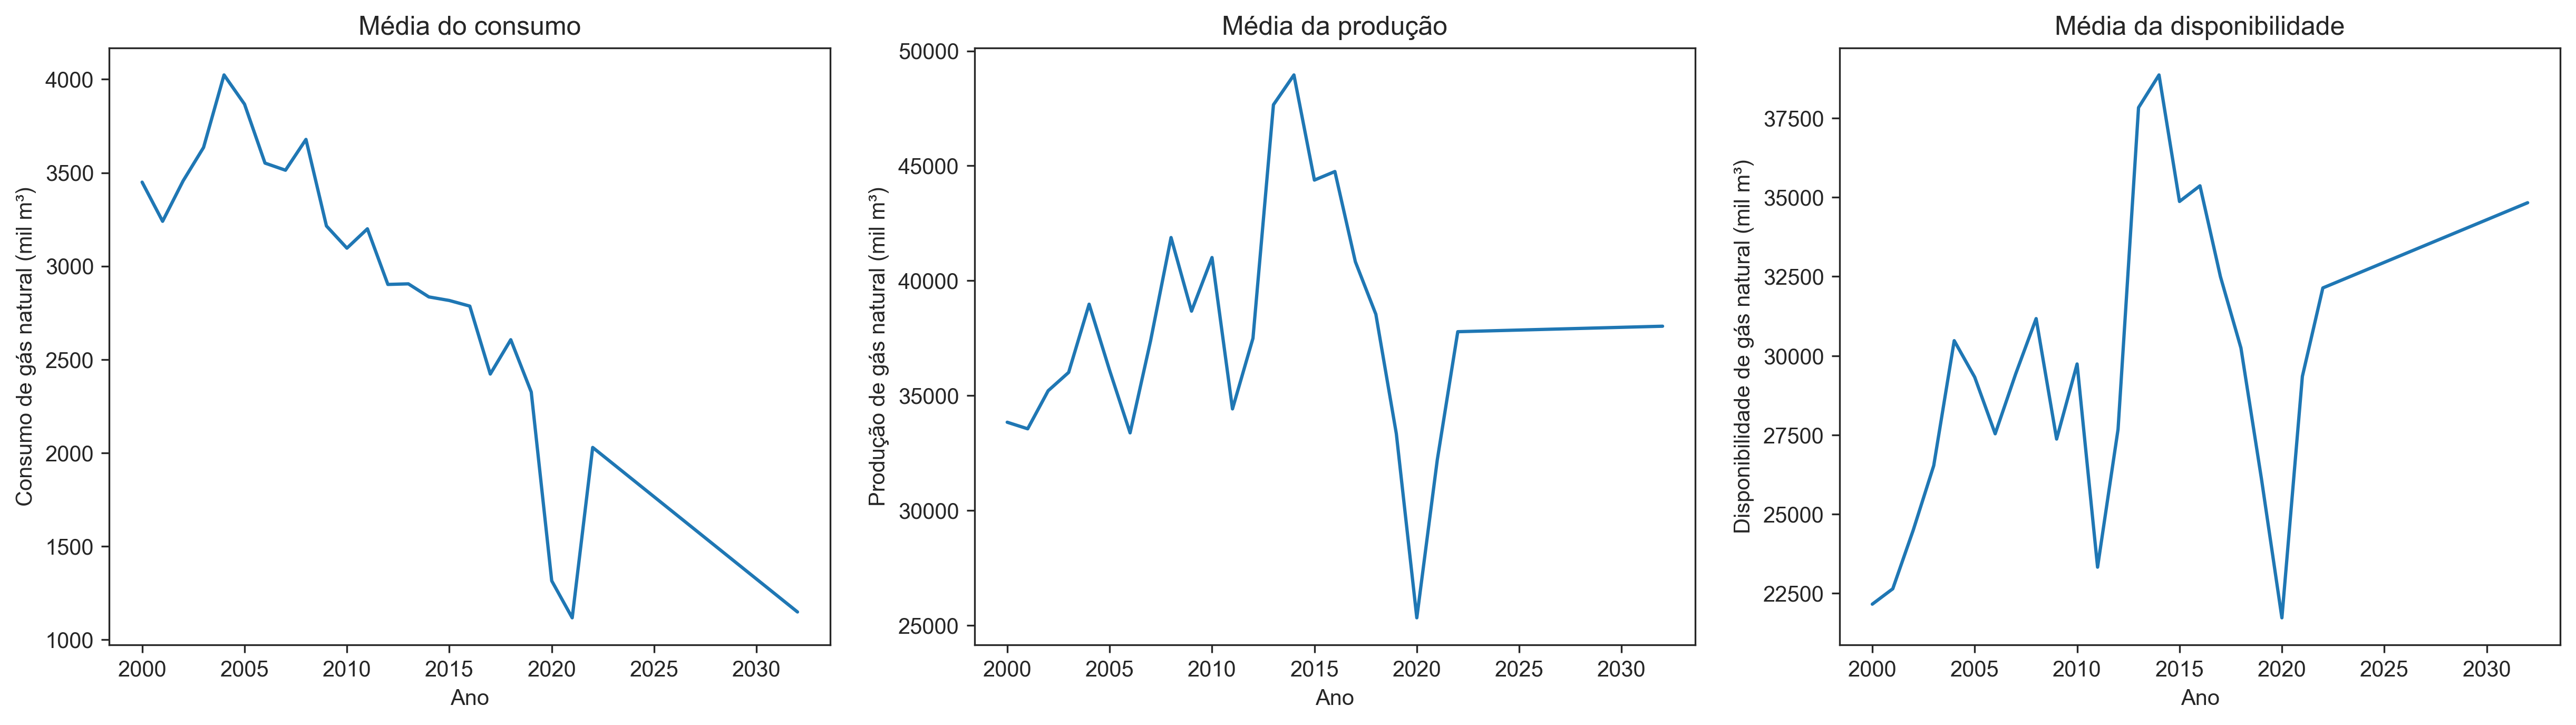

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(ax=axes[0],x="ano",y="consumo",data=media_nordeste_atual_pred)

axes[0].set_title("Média do consumo")
axes[0].set(xlabel='Ano', ylabel='Consumo de gás natural (mil m³)')

sns.lineplot(ax=axes[1],x="ano",y="producao",data=media_nordeste_atual_pred)
axes[1].set_title("Média da produção")
axes[1].set(xlabel='Ano', ylabel='Produção de gás natural (mil m³)')

sns.lineplot(ax=axes[2],x="ano",y="disponivel",data=media_nordeste_atual_pred)
axes[2].set_title("Média da disponibilidade")
axes[2].set(xlabel='Ano', ylabel='Disponibilidade de gás natural (mil m³)')

axes[0].ticklabel_format(style='plain', axis='y')
axes[1].ticklabel_format(style='plain', axis='y')
axes[2].ticklabel_format(style='plain', axis='y')

plt.show()

## Conclusão

Com este trabalho foi possível analisar de maneira detalhada os índices de produtividade, disponibilidade e consumo na região Nordeste do País ao longo das duas últimas décadas. Por meio dos mapas de calor, constatou-se que o potencial de geração de gás natural, na região Nordeste, apresenta-se promissor, uma vez que tanto os estados do Maranhão quanto da Bahia detêm grande disponibilidade desse recurso. Também foi possível comparar as variações nos valores desses índices, durante o período específico da pandemia, com os anos anteriores. Sendo assim, constatou-se que a região Nordeste apresentou uma queda acentuada no consumo, indo de 2,3 mil m³ (em 2019) para 1,1 mil m³ (em 2021). Também houve uma pequena queda na produção entre 2019 e 2020, porém em 2021 houve uma tendência de recuperação, e, esse nível, voltou a ser similar ao período pré-pandemia. Já com relação à disponibilidade, houve um crescimento importante entre 2019 (26,1 mil m³) e 2021 (29,3 mil m³). Esse aumento de disponibilidade confirma, mais uma vez, o potencial de exploração do gás natural nessa região.

Por fim, para análise da predição através da técnica de Regressão Linear, podemos concluir que: apesar da tendência da média de consumo para os estados do Nordeste estar em decréscimo, a tendência da média de disponbilidade está em crescimento. É válido notar que os fatores que podem influenciar o crescimento, ou não, dos valores para o consumo, produção e disponibilidade são diversos, sendo assim, não seria possível realizar uma predição de grande acurácia apenas com os dados aqui coletados, porém, acreditamos que ainda sejam válidos os valores aqui obtidos através do método de regressão linear, pois com isso é possível analisar a tendência com base nos anos anteriores.

## Referências bibliográficas

Companhia de Gás do Estado do Rio Grande do Sul - Sulgás. **Conheça o nosso produto: O GÁS NATURAL**. Disponível em: \<https://sulgas.rs.gov.br/sulgas/gas-natural>. Acesso em: 03 de *Dezembro* de 2021.

FRANCISCO, Wagner de Cerqueira e. Gás Natural. **Brasil Escola**. Disponível em: \<https://brasilescola.uol.com.br/geografia/fontes-gas-natural.htm>. Acesso em 03 de dezembro de 2021.

MIRKO, E. **Disponibilidade de Energia Termelétrica a gás natural na região centro-oeste**, 2009.

PRAÇA, E. R. **Distribuição de gás natural no Brasil: um enfoque crítico e de minimização de custos**. Dissertação (Mestrado em Ciências) - Fortaleza: DET/UFCE, 2003.

PRODUÇÃO de petróleo e gás natural por estado e localização. **Governo do Brasil**, 2021. Disponível em: \<https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/producao-de-petroleo-e-gas-natural-por-estado-e-localizacao>. Acesso em: 29 de Novembro de 2021.

SANTOS, E. M. **Gás Natural - estratégias para uma energia nova no Brasil**. Editora Annablume: 1ª Ed. Rio de Janeiro/RJ, 2002.

---



